In [1]:
############################################################
### Notebook to visualize and analyze the overhead times ###
### for starting and stopping ResidueFree. The data files###
### and scripts used to collect the data are in the      ###
### overhead_times folder                                ###
############################################################

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics

In [3]:
#Class to maintain the raw epoch times, and differences in seconds between different launch points
class LaunchMode:
    def __init__(self, name):
        self.name = name
        self.raw_times = []
        self.total_diffs = np.array([])
        self.res_diffs = np.array([])
        self.docker_diffs = np.array([])

In [4]:
# Times collected after ResidueFree had been used since boot
launchfile = open("./overhead_times/timing.txt")
launchlines = launchfile.read().splitlines()
base_launch_lines = launchlines[34:65]
#print(base_launch_lines)

In [5]:
# Initial launch times
daemon_test = open("./overhead_times/timing.txt")
daemon_lines = daemon_test.read().splitlines()
daemon_on_lines = daemon_lines[21:32]
daemon_off_lines = daemon_lines[9:19]

#print(daemon_on_lines)
#print(daemon_off_lines)

In [6]:
BaseLaunch = LaunchMode('Base')
NoDaemonInit = LaunchMode('NoDaemonInit')
YesDaemonInit = LaunchMode('YesDaemonInit')

Close_raw_times = []
Close_diffs = np.array([])

for tmp in base_launch_lines:
    tmp = list(map(int, tmp.split()))
    tmp = [int(i)/1000 for i in tmp] #convert to int
    
    #0 - start script, 1 - starting docker, 2 - inside residue free, 3 - end of script (after close)
    BaseLaunch.raw_times.append(tmp)
    BaseLaunch.total_diffs = np.append(BaseLaunch.total_diffs, tmp[2]-tmp[0])
    BaseLaunch.res_diffs = np.append(BaseLaunch.res_diffs, tmp[1]-tmp[0])
    BaseLaunch.docker_diffs = np.append(BaseLaunch.docker_diffs, tmp[2]-tmp[1])
    Close_diffs = np.append(Close_diffs, tmp[3]-tmp[2])

for tmp in daemon_off_lines:
    tmp = list(map(int, tmp.split()))
    tmp = [int(i)/1000 for i in tmp] #convert from milliseconds to seconds
    
    NoDaemonInit.raw_times.append(tmp)
    NoDaemonInit.total_diffs = np.append(NoDaemonInit.total_diffs, tmp[2]-tmp[0])
    NoDaemonInit.res_diffs = np.append(NoDaemonInit.res_diffs, tmp[1]-tmp[0])
    NoDaemonInit.docker_diffs = np.append(NoDaemonInit.docker_diffs, tmp[2]-tmp[1])
    
for tmp in daemon_on_lines:
    tmp = list(map(int, tmp.split()))
    tmp = [int(i)/1000 for i in tmp] #convert from milliseconds to seconds
    
    YesDaemonInit.raw_times.append(tmp)
    YesDaemonInit.total_diffs = np.append(YesDaemonInit.total_diffs, tmp[2]-tmp[0])
    YesDaemonInit.res_diffs = np.append(YesDaemonInit.res_diffs, tmp[1]-tmp[0])
    YesDaemonInit.docker_diffs = np.append(YesDaemonInit.docker_diffs, tmp[2]-tmp[1])

In [7]:
# Set standard plot options
def set_plot_options():
    options = {
        'backend': 'PDF',
        'font.size': 12,
        'figure.figsize': (4,2),
        'figure.dpi': 100.0,
        'figure.subplot.left': 0.20,
        'figure.subplot.right': 0.97,
        'figure.subplot.bottom': 0.20,
        'figure.subplot.top': 0.90,
        'grid.color': '0.1',
        'grid.linestyle': ':',
        #'grid.linewidth': 0.5,
        'axes.grid' : True,
        #'axes.grid.axis' : 'y',
        #'axes.axisbelow': True,
        'axes.titlesize' : 'medium',
        'axes.labelsize' : 'medium',
        'axes.formatter.limits': (-4,4),
        'xtick.labelsize' : 12,
        'ytick.labelsize' : 12,
        'lines.linewidth' : 2.0,
        'lines.markeredgewidth' : 0.5,
        'lines.markersize' : 10,
        'legend.fontsize' : 11,
        'legend.fancybox' : False,
        'legend.shadow' : False,
        'legend.borderaxespad' : 0.5,
        'legend.numpoints' : 1,
        'legend.handletextpad' : 0.5,
        'legend.handlelength' : 2.0,
        'legend.labelspacing' : .75,
        'legend.markerscale' : 1.0,
        # turn on the following to embedd fonts; requires latex
        'ps.useafm' : True,
        'pdf.use14corefonts' : True,
        'text.usetex' : True,
        'pdf.fonttype' : 42,
        'ps.fonttype' : 42,
    }

    for option_key in options:
        matplotlib.rcParams[option_key] = options[option_key]

    if 'figure.max_num_figures' in matplotlib.rcParams:
        matplotlib.rcParams['figure.max_num_figures'] = 50
    if 'figure.max_open_warning' in matplotlib.rcParams:
        matplotlib.rcParams['figure.max_open_warning'] = 50
    if 'legend.ncol' in matplotlib.rcParams:
        matplotlib.rcParams['legend.ncol'] = 50

In [8]:
#Set fonttype so it is not type3 (for publishing)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

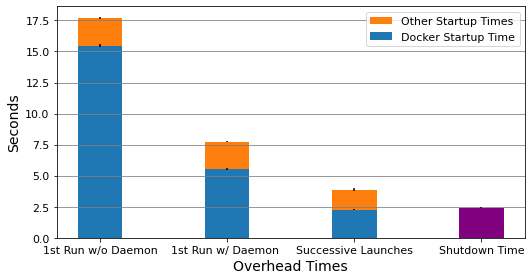

In [9]:
## Create stacked bar charts of total launch times broken up by Docker and non-Docker
#  Also display shutdown times (did not vary)

Docker_avgs = [np.mean(NoDaemonInit.docker_diffs), np.mean(YesDaemonInit.docker_diffs), np.mean(BaseLaunch.docker_diffs)]
Docker_stds = [np.std(NoDaemonInit.docker_diffs), np.std(YesDaemonInit.docker_diffs), np.std(BaseLaunch.docker_diffs)]
Other_avgs = [np.mean(NoDaemonInit.res_diffs), np.mean(YesDaemonInit.res_diffs), np.mean(BaseLaunch.res_diffs)]
Other_stds = [np.std(NoDaemonInit.res_diffs), np.std(YesDaemonInit.res_diffs), np.std(BaseLaunch.res_diffs)]

modes = [BaseLaunch, NoDaemonInit, YesDaemonInit]
fig, ax = plt.subplots()
ind = np.arange(len(modes))

width = 0.35

ax.bar(ind, Docker_avgs, width, yerr=Docker_stds, label="Docker Startup Time")
ax.bar(ind, Other_avgs, width, yerr=Other_stds, bottom=Docker_avgs, label="Other Startup Times")
ax.bar(3, np.mean(Close_diffs), width, yerr=np.std(Close_diffs),color='purple')

Ticks = ["1st Run w/o Daemon", "1st Run w/ Daemon ", "Successive Launches", "Shutdown Time"]

ax.set_ylabel("Seconds",fontsize=14)
ax.set_xlabel("Overhead Times",fontsize=14)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(Ticks, fontsize=11)

# Create legend but exlude Shutdown time bar
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=11)

# Display options / tweaking
fig.tight_layout()
plt.grid(b=True,which="major",axis="y",color='gray')
fig.set_size_inches(8, 4, forward=True)
plt.yticks(fontsize=11)
plt.style.use('tableau-colorblind10')
fig.set_facecolor('white')
plt.savefig("./Figures/Overhead.pdf")
plt.show()

In [10]:
# Print total average launch times for all three starting modes
print(np.mean(BaseLaunch.total_diffs))
print(np.mean(YesDaemonInit.total_diffs))
print(np.mean(NoDaemonInit.total_diffs))

3.884500002861023
7.737454544414174
17.694399976730345


In [11]:
print(np.mean(Close_diffs))

2.4380000193913776


In [12]:
# Print average Docker launch times for all three starting modes
print(np.mean(BaseLaunch.docker_diffs))
print(np.mean(YesDaemonInit.docker_diffs))
print(np.mean(NoDaemonInit.docker_diffs))

2.247166665395101
5.554636370051991
15.462300014495849


In [13]:
# Print non-Docker (ResidueFree core) for all three starting modes
print(np.mean(BaseLaunch.res_diffs))
print(np.mean(YesDaemonInit.res_diffs))
print(np.mean(NoDaemonInit.res_diffs))

1.637333337465922
2.1828181743621826
2.2320999622344972
